<a href="https://colab.research.google.com/github/whoisakshatgarg/102116084-SESS_LE1/blob/main/102116084_AkshatGarg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: **Akshat Garg**  
Email: `agarg_be21@thapar.edu`  
Roll No: **102116084**  
Group: **4CS11**  
Start Timestamp: Wed Sep 11 2024 10:00 AM

## Paper Summary

The paper "Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition" by Pete Warden describes a dataset designed for training and evaluating keyword spotting systems. It outlines the dataset's creation, containing spoken words to detect specific commands, and discusses its motivation, collection process, and evaluation methodology. The dataset, released under Creative Commons BY 4.0, includes various words, background noises, and is aimed at enabling accurate, energy-efficient, on-device speech recognition models.

## Question
 Consider the paper: <https://arxiv.org/abs/1804.03209>

  1. Read and summarise the paper in about 50 words.
  2. Download the dataset in the paper, statistically analyse and
     describe it, so that it may be useful for posterity. (Include code
     snippets in your .ipynb file to evidence your analysis.)
  3. Train a classifier so that you are able to distinguish the commands
     in the dataset.
  4. Report the performance results using standard benchmarks.
  5. Record about 30 samples of each command in your voice and create a
     new dataset (including a new user id for yourself).  You may use a
     timer on your computer to synchronise.
  6. Fine tune your classifier to perform on your voice.
  7. Report the results.


## Solution

In [ ]:
%matplotlib inline

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm
!pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.7.0+cu101 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

In [ ]:
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

100%|██████████| 2.26G/2.26G [00:31<00:00, 77.3MB/s]


In [ ]:
len(train_set)

84843

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000
Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


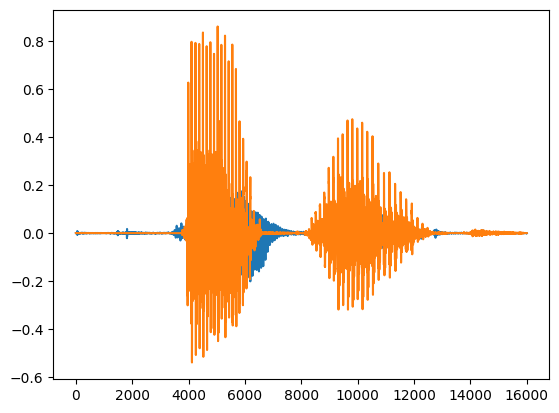

In [ ]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[50]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

waveform, sample_rate, label, speaker_id, utterance_number = train_set[25]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

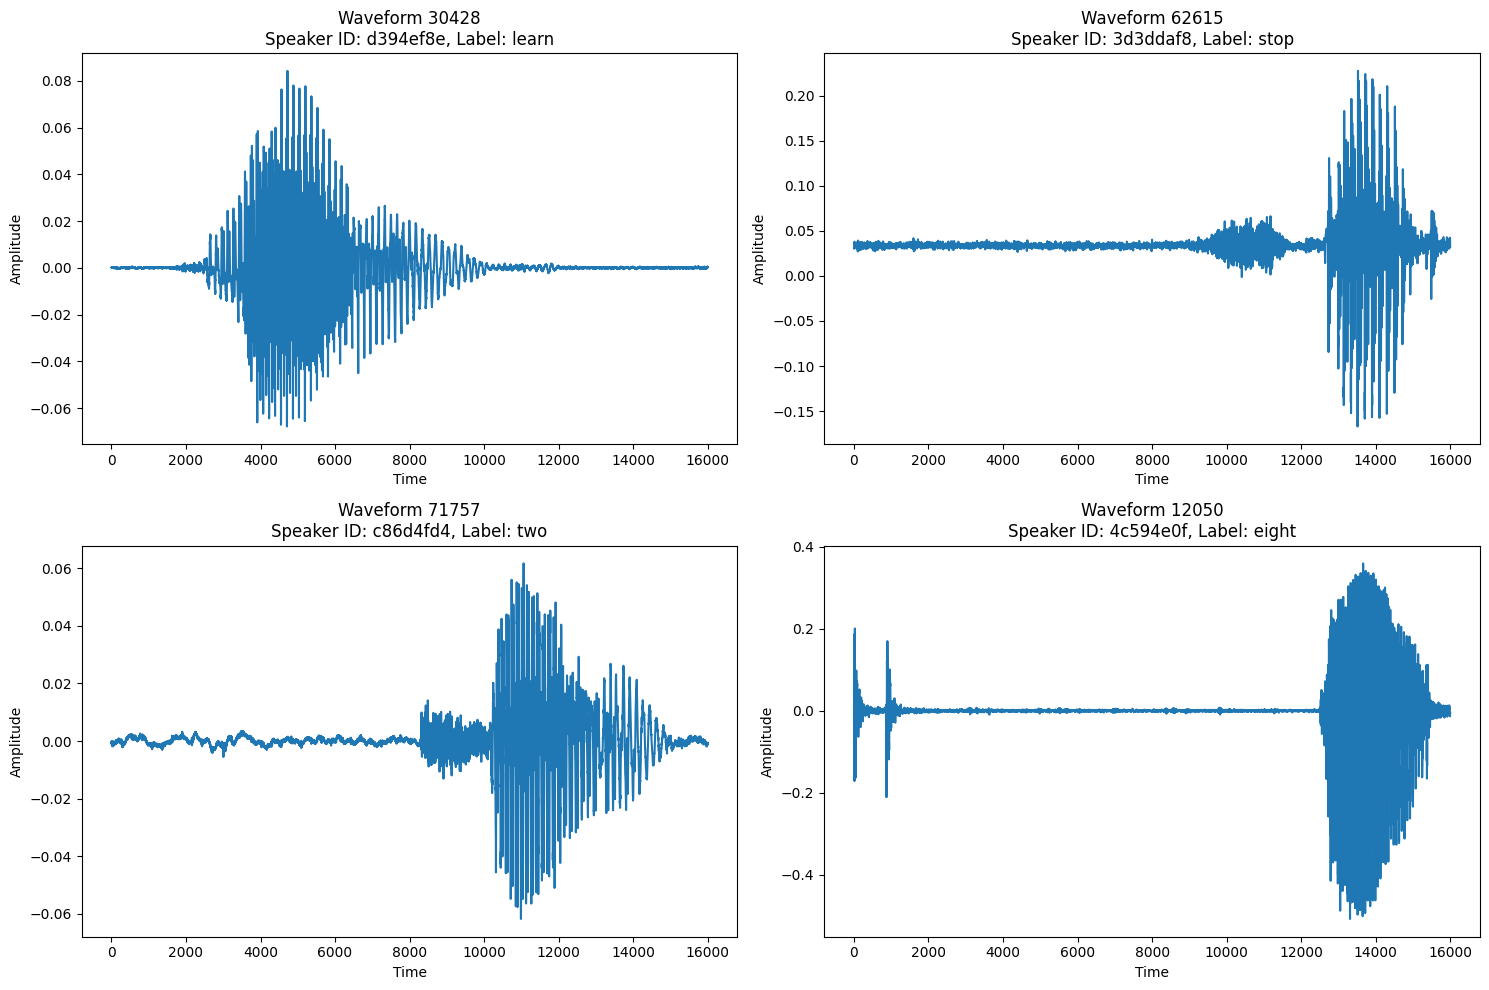

In [ ]:
import random
def plot_random_waveforms(train_set, num_samples=4):
    # Randomly select num_samples from the dataset
    selected_indices = random.sample(range(len(train_set)), num_samples)

    # Create a 2x2 grid for plotting
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Flatten the 2x2 grid for easier indexing
    axs = axs.flatten()

    # Plot each selected waveform
    for i, idx in enumerate(selected_indices):
        waveform, sample_rate, label, speaker_id, utterance_number = train_set[idx]
        waveform_np = waveform.t().numpy()

        axs[i].plot(waveform_np)
        axs[i].set_title(f"Waveform {idx}\nSpeaker ID: {speaker_id}, Label: {label}")
        axs[i].set_xlabel("Time")
        axs[i].set_ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

# Call the function to plot 4 random waveforms
plot_random_waveforms(train_set)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
from scipy.stats import describe
import tqdm

# Initialize lists to store statistics for each sample
mean_list = []
std_list = []
min_list = []
max_list = []
speaker_ids = []

# Process each sample
for i in tqdm.tqdm(range(len(train_set))):
    waveform, sample_rate, label, speaker_id, utterance_number = train_set[i]
    waveform_np = waveform.t().numpy()

    # Calculate statistics for the current sample
    mean_list.append(np.mean(waveform_np))
    std_list.append(np.std(waveform_np))
    min_list.append(np.min(waveform_np))
    max_list.append(np.max(waveform_np))
    speaker_ids.append(speaker_id)

# Convert lists to numpy arrays for easier handling
mean_list = np.array(mean_list)
std_list = np.array(std_list)
min_list = np.array(min_list)
max_list = np.array(max_list)
speaker_ids = np.array(speaker_ids)

# Aggregate statistics
overall_stats = {
    'mean': describe(mean_list),
    'std': describe(std_list),
    'min': describe(min_list),
    'max': describe(max_list)
}

100%|██████████| 84843/84843 [06:59<00:00, 202.04it/s]


Overall Statistics:

Mean:
DescribeResult(nobs=84843, minmax=(-0.23036173, 0.33127502), mean=-9.044767e-05, variance=6.016240846908551e-05, skewness=-15.945629125918895, kurtosis=541.6353986593274)

Std:
DescribeResult(nobs=84843, minmax=(0.0001796303, 0.74539423), mean=0.06969454, variance=0.002665923432397751, skewness=2.275627330265921, kurtosis=10.74368950785939)

Min:
DescribeResult(nobs=84843, minmax=(-1.0, 0.079711914), mean=-0.46494624, variance=0.07110036520295694, skewness=-0.3377616091810901, kurtosis=-0.9459128598134305)

Max:
DescribeResult(nobs=84843, minmax=(-0.18209839, 0.9999695), mean=0.46626222, variance=0.07256359452212376, skewness=0.32938595182937963, kurtosis=-0.9735917256792077)



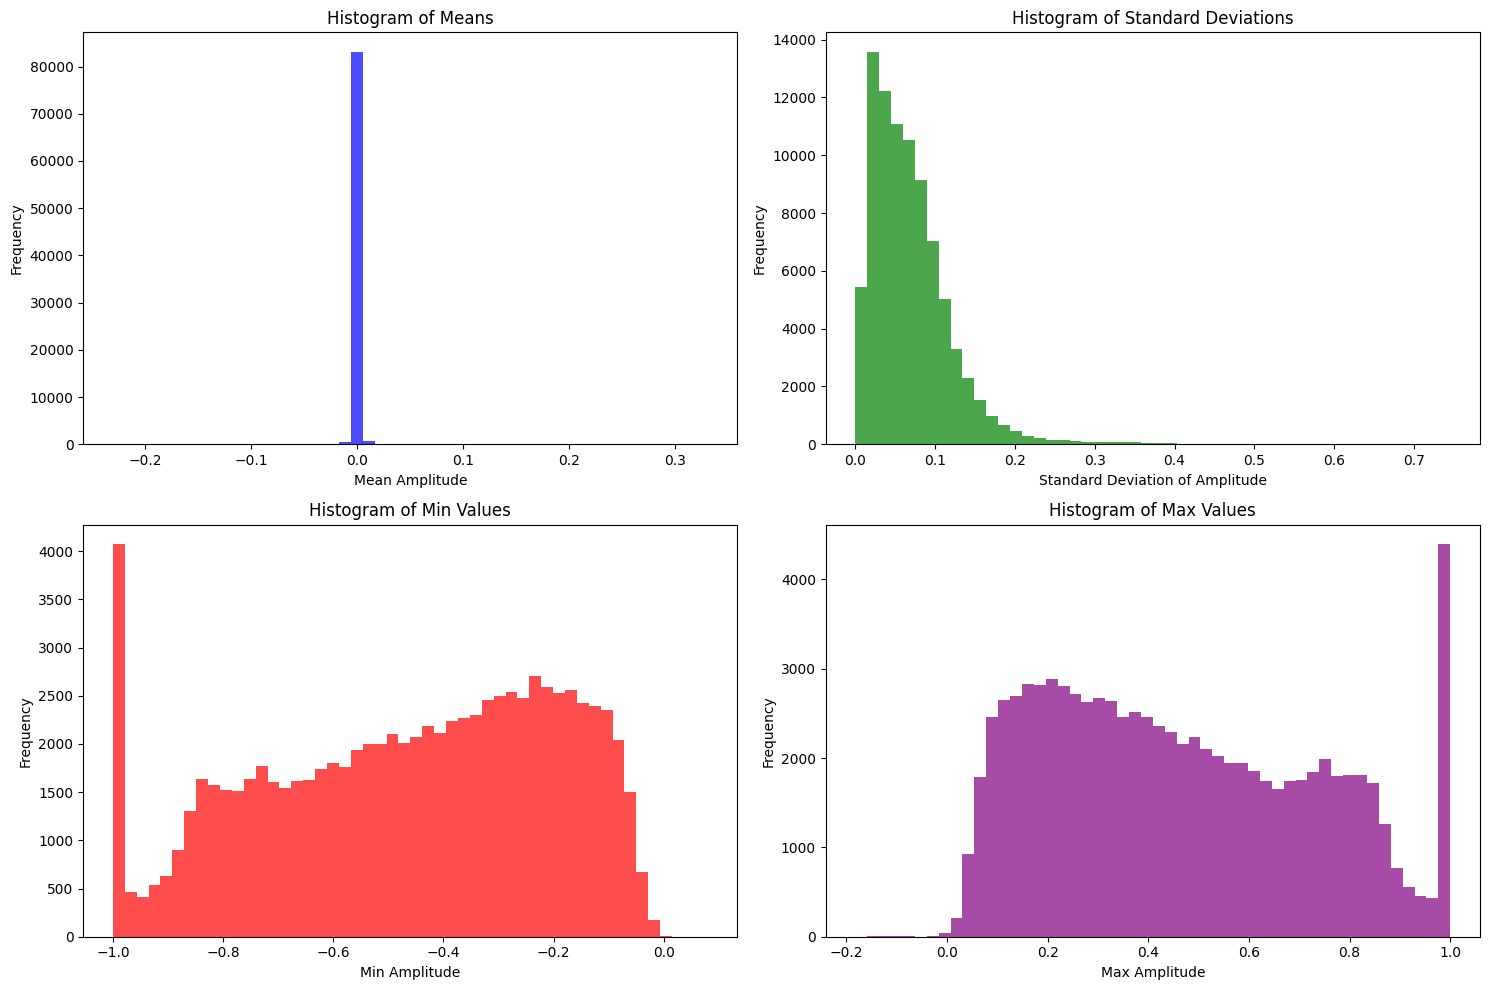

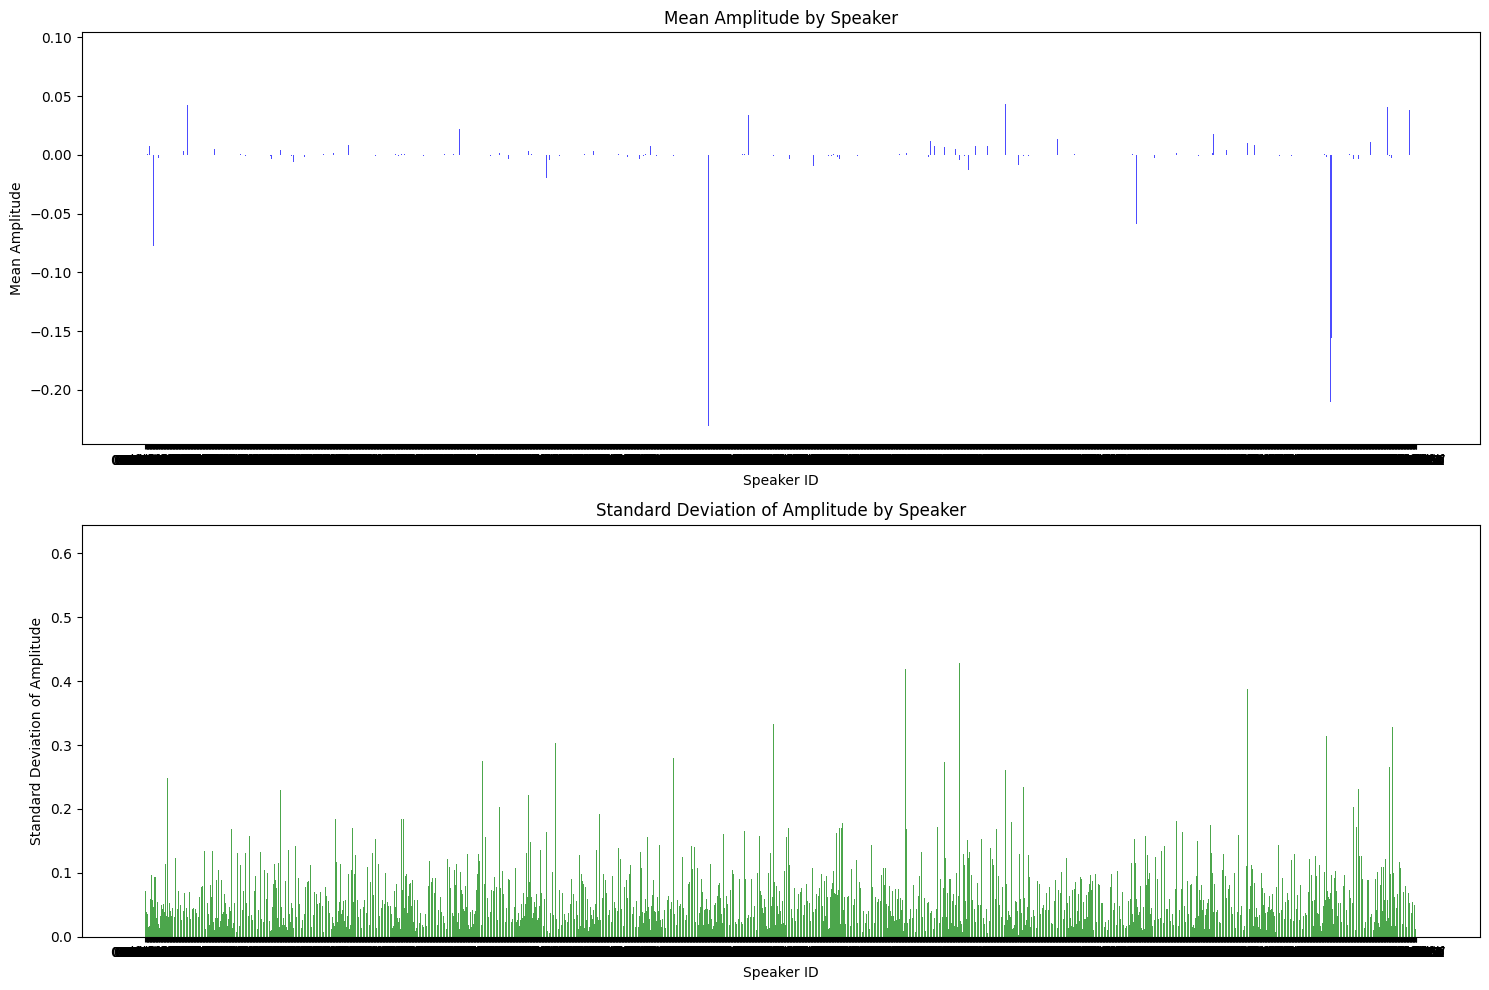

In [ ]:
print("Overall Statistics:\n")
for key, stats in overall_stats.items():
    print(f"{key.capitalize()}:\n{stats}\n")
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Histogram of means
axs[0, 0].hist(mean_list, bins=50, alpha=0.7, color='blue')
axs[0, 0].set_title("Histogram of Means")
axs[0, 0].set_xlabel("Mean Amplitude")
axs[0, 0].set_ylabel("Frequency")

# Histogram of standard deviations
axs[0, 1].hist(std_list, bins=50, alpha=0.7, color='green')
axs[0, 1].set_title("Histogram of Standard Deviations")
axs[0, 1].set_xlabel("Standard Deviation of Amplitude")
axs[0, 1].set_ylabel("Frequency")

# Histogram of min values
axs[1, 0].hist(min_list, bins=50, alpha=0.7, color='red')
axs[1, 0].set_title("Histogram of Min Values")
axs[1, 0].set_xlabel("Min Amplitude")
axs[1, 0].set_ylabel("Frequency")

# Histogram of max values
axs[1, 1].hist(max_list, bins=50, alpha=0.7, color='purple')
axs[1, 1].set_title("Histogram of Max Values")
axs[1, 1].set_xlabel("Max Amplitude")
axs[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Analysis grouped by speaker
unique_speakers = np.unique(speaker_ids)
speaker_means = [np.mean(mean_list[speaker_ids == sp]) for sp in unique_speakers]
speaker_stds = [np.mean(std_list[speaker_ids == sp]) for sp in unique_speakers]

# Create a grid for speaker analysis
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Mean amplitude by speaker
axs[0].bar(unique_speakers, speaker_means, alpha=0.7, color='blue')
axs[0].set_title("Mean Amplitude by Speaker")
axs[0].set_xlabel("Speaker ID")
axs[0].set_ylabel("Mean Amplitude")

# Standard deviation of amplitude by speaker
axs[1].bar(unique_speakers, speaker_stds, alpha=0.7, color='green')
axs[1].set_title("Standard Deviation of Amplitude by Speaker")
axs[1].set_xlabel("Speaker ID")
axs[1].set_ylabel("Standard Deviation of Amplitude")

plt.tight_layout()
plt.show()

In [ ]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [ ]:
len(labels)

35

In [ ]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

In [ ]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

## Formatting the Data

In [ ]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [ ]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [ ]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [ ]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(1)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [ ]:
log_interval = 20
n_epoch = 10

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm.tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

  0%|          | 0.0026666666666666666/10 [00:01<2:01:09, 727.17s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.903666


  1%|          | 0.05599999999999999/10 [00:29<1:25:12, 514.08s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.161998


  1%|          | 0.10933333333333328/10 [00:57<1:23:26, 506.21s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.588882


  2%|▏         | 0.16266666666666676/10 [01:25<1:19:54, 487.39s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.284023


  2%|▏         | 0.21600000000000033/10 [01:53<1:19:58, 490.47s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 2.113343


  3%|▎         | 0.2693333333333337/10 [02:21<1:18:43, 485.40s/it] 

Train Epoch: 1 [25600/84843 (30%)]	Loss: 2.074296


  3%|▎         | 0.3226666666666667/10 [02:52<1:33:28, 579.59s/it] 

Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.768548


  4%|▍         | 0.3759999999999997/10 [03:20<1:25:01, 530.04s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.732835


  4%|▍         | 0.42933333333333273/10 [03:48<1:22:38, 518.05s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.525052


  5%|▍         | 0.48266666666666574/10 [04:18<1:19:07, 498.81s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.658840


  5%|▌         | 0.5359999999999995/10 [04:51<1:36:12, 609.90s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.401211


  6%|▌         | 0.5893333333333336/10 [05:20<1:22:03, 523.15s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.198435


  6%|▋         | 0.6426666666666677/10 [05:49<1:18:26, 503.02s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 1.210209


  7%|▋         | 0.6960000000000018/10 [06:17<1:17:37, 500.64s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 1.229058


  7%|▋         | 0.749333333333336/10 [06:46<1:33:41, 607.65s/it] 

Train Epoch: 1 [71680/84843 (84%)]	Loss: 1.289513


  8%|▊         | 0.8026666666666701/10 [07:15<1:26:08, 561.93s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.139218


  9%|▊         | 0.8560000000000042/10 [07:43<1:19:45, 523.40s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 1.177654


43.885333333333335it [09:07,  1.32s/it]


Test Epoch: 1	Accuracy: 6325/11005 (57%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 0.990311
Train Epoch: 2 [5120/84843 (6%)]	Loss: 1.178368


43.96533333333343it [09:49, 19.15s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 1.083837


44.02400000000017it [10:20, 43.12s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 1.005896


44.09600000000026it [10:58, 114.66s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 0.922109


44.15200000000033it [11:27, 264.67s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 1.032522


44.208000000000396it [11:56, 484.86s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.958080


44.261333333333795it [12:24, 514.74s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.960197


44.31466666666719it [12:57, 972.38s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 1.035324


44.36800000000059it [13:27, 539.57s/it]

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.807097


44.42133333333399it [13:55, 516.12s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 1.042241


44.47466666666739it [14:23, 502.99s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 1.057795


44.52800000000079it [14:51, 493.20s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.882030


44.581333333334186it [15:20, 567.17s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.873774


44.634666666667584it [15:49, 581.43s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 1.019393


44.68800000000098it [16:17, 546.13s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.784535


44.74133333333438it [16:45, 516.93s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.861113


87.77066666666775it [18:03,  1.44s/it]


Test Epoch: 2	Accuracy: 6766/11005 (61%)

Train Epoch: 3 [0/84843 (0%)]	Loss: 0.725184
Train Epoch: 3 [5120/84843 (6%)]	Loss: 0.791629


87.84533333333451it [18:42, 17.79s/it]

Train Epoch: 3 [10240/84843 (12%)]	Loss: 0.826210


87.8986666666679it [19:09, 39.69s/it] 

Train Epoch: 3 [15360/84843 (18%)]	Loss: 0.915414


87.98666666666801it [19:56, 152.62s/it]

Train Epoch: 3 [20480/84843 (24%)]	Loss: 0.906726


88.04000000000141it [20:24, 385.89s/it]

Train Epoch: 3 [25600/84843 (30%)]	Loss: 0.866722


88.09333333333481it [20:52, 518.02s/it]

Train Epoch: 3 [30720/84843 (36%)]	Loss: 0.913300


88.14666666666821it [21:19, 500.38s/it]

Train Epoch: 3 [35840/84843 (42%)]	Loss: 0.745365


88.20000000000161it [21:47, 565.09s/it]

Train Epoch: 3 [40960/84843 (48%)]	Loss: 0.864711


88.25333333333501it [22:15, 490.19s/it]

Train Epoch: 3 [46080/84843 (54%)]	Loss: 0.704091


88.3066666666684it [22:44, 569.42s/it] 

Train Epoch: 3 [51200/84843 (60%)]	Loss: 0.854470


88.3600000000018it [23:17, 588.81s/it] 

Train Epoch: 3 [56320/84843 (66%)]	Loss: 0.739054


88.4133333333352it [23:47, 515.59s/it] 

Train Epoch: 3 [61440/84843 (72%)]	Loss: 0.671348


88.4666666666686it [24:17, 589.62s/it] 

Train Epoch: 3 [66560/84843 (78%)]	Loss: 0.631510


88.520000000002it [24:48, 542.90s/it]  

Train Epoch: 3 [71680/84843 (84%)]	Loss: 0.771889


88.5733333333354it [25:17, 517.93s/it] 

Train Epoch: 3 [76800/84843 (90%)]	Loss: 0.661732


88.6266666666688it [25:47, 584.63s/it] 

Train Epoch: 3 [81920/84843 (96%)]	Loss: 0.760036


131.65600000000217it [26:58,  1.24s/it]


Test Epoch: 3	Accuracy: 7251/11005 (66%)

Train Epoch: 4 [0/84843 (0%)]	Loss: 0.746840
Train Epoch: 4 [5120/84843 (6%)]	Loss: 0.606170


131.7413333333356it [27:43, 20.03s/it] 

Train Epoch: 4 [10240/84843 (12%)]	Loss: 0.770255


131.802666666669it [28:15, 45.30s/it]  

Train Epoch: 4 [15360/84843 (18%)]	Loss: 0.676181


131.8480000000024it [28:39, 79.75s/it] 

Train Epoch: 4 [20480/84843 (24%)]	Loss: 0.808036


131.9200000000025it [29:17, 223.78s/it] 

Train Epoch: 4 [25600/84843 (30%)]	Loss: 0.796253


131.97866666666923it [29:48, 484.01s/it]

Train Epoch: 4 [30720/84843 (36%)]	Loss: 0.789888


132.03200000000263it [30:16, 492.23s/it]

Train Epoch: 4 [35840/84843 (42%)]	Loss: 0.571696


132.08533333333602it [30:46, 581.83s/it]

Train Epoch: 4 [40960/84843 (48%)]	Loss: 0.602713


132.13866666666942it [31:14, 531.75s/it]

Train Epoch: 4 [46080/84843 (54%)]	Loss: 0.727612


132.19200000000282it [31:42, 505.56s/it]

Train Epoch: 4 [51200/84843 (60%)]	Loss: 0.670436


132.24533333333622it [32:10, 500.20s/it]

Train Epoch: 4 [56320/84843 (66%)]	Loss: 0.706906


132.29866666666962it [32:38, 491.92s/it]

Train Epoch: 4 [61440/84843 (72%)]	Loss: 0.726227


132.35200000000302it [33:07, 551.10s/it]

Train Epoch: 4 [66560/84843 (78%)]	Loss: 0.763541


132.40533333333642it [33:44, 609.22s/it]

Train Epoch: 4 [71680/84843 (84%)]	Loss: 0.721694


132.4586666666698it [34:18, 621.97s/it] 

Train Epoch: 4 [76800/84843 (90%)]	Loss: 0.686787


132.5120000000032it [34:52, 679.19s/it] 

Train Epoch: 4 [81920/84843 (96%)]	Loss: 0.590713


175.54133333333658it [36:05,  1.21s/it]


Test Epoch: 4	Accuracy: 8660/11005 (79%)

Train Epoch: 5 [0/84843 (0%)]	Loss: 0.653262
Train Epoch: 5 [5120/84843 (6%)]	Loss: 0.627259


175.6293333333367it [36:53, 21.19s/it] 

Train Epoch: 5 [10240/84843 (12%)]	Loss: 0.517138


175.69333333333677it [37:28, 48.82s/it]

Train Epoch: 5 [15360/84843 (18%)]	Loss: 0.610522


175.73866666667016it [37:52, 82.66s/it]

Train Epoch: 5 [20480/84843 (24%)]	Loss: 0.501770


175.81066666667024it [38:31, 228.15s/it]

Train Epoch: 5 [25600/84843 (30%)]	Loss: 0.556113


175.86400000000364it [39:01, 547.72s/it]

Train Epoch: 5 [30720/84843 (36%)]	Loss: 0.642266


175.91733333333704it [39:31, 584.40s/it]

Train Epoch: 5 [35840/84843 (42%)]	Loss: 0.765981


175.97066666667044it [39:59, 517.66s/it]

Train Epoch: 5 [40960/84843 (48%)]	Loss: 0.757571


176.02400000000384it [40:27, 504.69s/it]

Train Epoch: 5 [46080/84843 (54%)]	Loss: 0.603778


176.07733333333724it [40:57, 587.16s/it]

Train Epoch: 5 [51200/84843 (60%)]	Loss: 0.648651


176.13066666667063it [41:25, 564.41s/it]

Train Epoch: 5 [56320/84843 (66%)]	Loss: 0.748657


176.18400000000403it [41:54, 525.09s/it]

Train Epoch: 5 [61440/84843 (72%)]	Loss: 0.656808


176.23733333333743it [42:22, 507.84s/it]

Train Epoch: 5 [66560/84843 (78%)]	Loss: 0.707583


176.29066666667083it [42:50, 497.14s/it]

Train Epoch: 5 [71680/84843 (84%)]	Loss: 0.638412


176.34400000000423it [43:20, 607.66s/it]

Train Epoch: 5 [76800/84843 (90%)]	Loss: 0.651156


176.39733333333763it [43:58, 607.89s/it]

Train Epoch: 5 [81920/84843 (96%)]	Loss: 0.664215


219.426666666671it [45:14,  1.22s/it]


Test Epoch: 5	Accuracy: 8412/11005 (76%)

Train Epoch: 6 [0/84843 (0%)]	Loss: 0.589935
Train Epoch: 6 [5120/84843 (6%)]	Loss: 0.627178


219.5146666666711it [46:01, 20.64s/it] 

Train Epoch: 6 [10240/84843 (12%)]	Loss: 0.565900


219.5760000000045it [46:33, 45.66s/it] 

Train Epoch: 6 [15360/84843 (18%)]	Loss: 0.592718


219.6213333333379it [46:57, 79.49s/it] 

Train Epoch: 6 [20480/84843 (24%)]	Loss: 0.610609


219.693333333338it [47:35, 224.57s/it]  

Train Epoch: 6 [25600/84843 (30%)]	Loss: 0.713674


219.74933333333806it [48:04, 481.41s/it]

Train Epoch: 6 [30720/84843 (36%)]	Loss: 0.559120


219.80266666667146it [48:33, 489.83s/it]

Train Epoch: 6 [35840/84843 (42%)]	Loss: 0.606753


219.85600000000485it [49:02, 539.45s/it]

Train Epoch: 6 [40960/84843 (48%)]	Loss: 0.617456


219.90933333333825it [49:30, 594.48s/it]

Train Epoch: 6 [46080/84843 (54%)]	Loss: 0.728008


219.96266666667165it [49:58, 553.15s/it]

Train Epoch: 6 [51200/84843 (60%)]	Loss: 0.553980


220.01600000000505it [50:26, 524.49s/it]

Train Epoch: 6 [56320/84843 (66%)]	Loss: 0.619662


220.06933333333845it [50:55, 513.55s/it]

Train Epoch: 6 [61440/84843 (72%)]	Loss: 0.616042


220.12266666667185it [51:23, 486.08s/it]

Train Epoch: 6 [66560/84843 (78%)]	Loss: 0.682945


220.17600000000525it [51:51, 484.31s/it]

Train Epoch: 6 [71680/84843 (84%)]	Loss: 0.595967


220.22933333333864it [52:18, 487.31s/it]

Train Epoch: 6 [76800/84843 (90%)]	Loss: 0.657845


220.28266666667204it [52:48, 581.80s/it]

Train Epoch: 6 [81920/84843 (96%)]	Loss: 0.686560


263.3120000000054it [54:02,  1.23s/it]


Test Epoch: 6	Accuracy: 8525/11005 (77%)

Train Epoch: 7 [0/84843 (0%)]	Loss: 0.633723
Train Epoch: 7 [5120/84843 (6%)]	Loss: 0.729060


263.39733333333794it [54:51, 21.72s/it]

Train Epoch: 7 [10240/84843 (12%)]	Loss: 0.671434


263.4586666666707it [55:26, 49.39s/it] 

Train Epoch: 7 [15360/84843 (18%)]	Loss: 0.613315


263.5040000000036it [55:53, 87.23s/it] 

Train Epoch: 7 [20480/84843 (24%)]	Loss: 0.531040


263.5760000000029it [56:33, 240.06s/it]

Train Epoch: 7 [25600/84843 (30%)]	Loss: 0.557285


263.63466666666903it [57:07, 563.36s/it]

Train Epoch: 7 [30720/84843 (36%)]	Loss: 0.624825


263.68800000000186it [57:37, 558.01s/it]

Train Epoch: 7 [35840/84843 (42%)]	Loss: 0.597826


263.7413333333347it [58:06, 534.47s/it] 

Train Epoch: 7 [40960/84843 (48%)]	Loss: 0.616303


263.7946666666675it [58:36, 532.12s/it]

Train Epoch: 7 [46080/84843 (54%)]	Loss: 0.666877


263.84800000000035it [59:06, 582.12s/it]

Train Epoch: 7 [51200/84843 (60%)]	Loss: 0.733474


263.9013333333332it [59:35, 530.24s/it] 

Train Epoch: 7 [56320/84843 (66%)]	Loss: 0.637822


263.954666666666it [1:00:05, 518.66s/it] 

Train Epoch: 7 [61440/84843 (72%)]	Loss: 0.606314


264.00799999999884it [1:00:35, 618.10s/it]

Train Epoch: 7 [66560/84843 (78%)]	Loss: 0.738436


264.0613333333317it [1:01:04, 543.70s/it] 

Train Epoch: 7 [71680/84843 (84%)]	Loss: 0.527975


264.1146666666645it [1:01:34, 512.24s/it] 

Train Epoch: 7 [76800/84843 (90%)]	Loss: 0.558673


264.16799999999733it [1:02:03, 543.83s/it]

Train Epoch: 7 [81920/84843 (96%)]	Loss: 0.760568


307.1973333333304it [1:03:14,  1.30s/it]


Test Epoch: 7	Accuracy: 8393/11005 (76%)

Train Epoch: 8 [0/84843 (0%)]	Loss: 0.519439
Train Epoch: 8 [5120/84843 (6%)]	Loss: 0.485043


307.2799999999963it [1:04:02, 21.45s/it] 

Train Epoch: 8 [10240/84843 (12%)]	Loss: 0.649612


307.3386666666624it [1:04:35, 47.28s/it] 

Train Epoch: 8 [15360/84843 (18%)]	Loss: 0.594711


307.41333333332835it [1:05:16, 123.63s/it]

Train Epoch: 8 [20480/84843 (24%)]	Loss: 0.731186


307.46399999999454it [1:05:44, 270.04s/it]

Train Epoch: 8 [25600/84843 (30%)]	Loss: 0.571215


307.519999999994it [1:06:16, 614.72s/it] 

Train Epoch: 8 [30720/84843 (36%)]	Loss: 0.447487


307.57333333332684it [1:06:45, 546.83s/it]

Train Epoch: 8 [35840/84843 (42%)]	Loss: 0.600772


307.6266666666597it [1:07:14, 521.09s/it] 

Train Epoch: 8 [40960/84843 (48%)]	Loss: 0.487780


307.6799999999925it [1:07:43, 507.08s/it] 

Train Epoch: 8 [46080/84843 (54%)]	Loss: 0.639535


307.73333333332533it [1:08:13, 600.08s/it]

Train Epoch: 8 [51200/84843 (60%)]	Loss: 0.635591


307.78666666665816it [1:08:42, 560.46s/it]

Train Epoch: 8 [56320/84843 (66%)]	Loss: 0.567510


307.839999999991it [1:09:11, 532.23s/it]  

Train Epoch: 8 [61440/84843 (72%)]	Loss: 0.545426


307.8933333333238it [1:09:39, 509.88s/it]

Train Epoch: 8 [66560/84843 (78%)]	Loss: 0.652476


307.94666666665665it [1:10:09, 575.09s/it]

Train Epoch: 8 [71680/84843 (84%)]	Loss: 0.644977


307.9999999999895it [1:10:39, 590.40s/it] 

Train Epoch: 8 [76800/84843 (90%)]	Loss: 0.470245


308.0533333333223it [1:11:07, 524.73s/it]

Train Epoch: 8 [81920/84843 (96%)]	Loss: 0.619793


351.08266666665537it [1:12:16,  1.18s/it]


Test Epoch: 8	Accuracy: 8227/11005 (75%)

Train Epoch: 9 [0/84843 (0%)]	Loss: 0.539176
Train Epoch: 9 [5120/84843 (6%)]	Loss: 0.603651


351.17066666665454it [1:13:03, 20.56s/it]

Train Epoch: 9 [10240/84843 (12%)]	Loss: 0.540237


351.23466666665394it [1:13:35, 45.69s/it]

Train Epoch: 9 [15360/84843 (18%)]	Loss: 0.515004


351.27999999998684it [1:14:00, 80.84s/it]

Train Epoch: 9 [20480/84843 (24%)]	Loss: 0.619288


351.33866666665295it [1:14:37, 196.03s/it]

Train Epoch: 9 [25600/84843 (30%)]	Loss: 0.722762


351.405333333319it [1:15:14, 542.89s/it]  

Train Epoch: 9 [30720/84843 (36%)]	Loss: 0.507604


351.4586666666518it [1:15:43, 537.74s/it]

Train Epoch: 9 [35840/84843 (42%)]	Loss: 0.601416


351.51199999998465it [1:16:12, 523.80s/it]

Train Epoch: 9 [40960/84843 (48%)]	Loss: 0.501840


351.5653333333175it [1:16:42, 559.40s/it] 

Train Epoch: 9 [46080/84843 (54%)]	Loss: 0.681786


351.6186666666503it [1:17:11, 566.46s/it] 

Train Epoch: 9 [51200/84843 (60%)]	Loss: 0.623716


351.67199999998314it [1:17:40, 529.17s/it]

Train Epoch: 9 [56320/84843 (66%)]	Loss: 0.526755


351.725333333316it [1:18:09, 519.32s/it]  

Train Epoch: 9 [61440/84843 (72%)]	Loss: 0.500657


351.7786666666488it [1:18:41, 733.96s/it] 

Train Epoch: 9 [66560/84843 (78%)]	Loss: 0.634177


351.83199999998163it [1:19:10, 565.43s/it]

Train Epoch: 9 [71680/84843 (84%)]	Loss: 0.574278


351.88533333331446it [1:19:39, 534.24s/it]

Train Epoch: 9 [76800/84843 (90%)]	Loss: 0.596141


351.9386666666473it [1:20:08, 512.99s/it] 

Train Epoch: 9 [81920/84843 (96%)]	Loss: 0.616042


394.96799999998035it [1:21:23,  1.67s/it]


Test Epoch: 9	Accuracy: 8337/11005 (76%)

Train Epoch: 10 [0/84843 (0%)]	Loss: 0.630327
Train Epoch: 10 [5120/84843 (6%)]	Loss: 0.626057


395.07733333331265it [1:22:20, 35.14s/it]

Train Epoch: 10 [10240/84843 (12%)]	Loss: 0.567825


395.111999999979it [1:22:39, 62.68s/it]  

Train Epoch: 10 [15360/84843 (18%)]	Loss: 0.479565


395.1839999999783it [1:23:16, 264.32s/it] 

Train Epoch: 10 [20480/84843 (24%)]	Loss: 0.486449


395.23733333331114it [1:23:45, 523.89s/it]

Train Epoch: 10 [25600/84843 (30%)]	Loss: 0.587857


395.290666666644it [1:24:14, 612.99s/it]  

Train Epoch: 10 [30720/84843 (36%)]	Loss: 0.615793


395.3439999999768it [1:24:48, 633.36s/it] 

Train Epoch: 10 [35840/84843 (42%)]	Loss: 0.467288


395.39733333330963it [1:25:18, 565.05s/it]

Train Epoch: 10 [40960/84843 (48%)]	Loss: 0.569855


395.45066666664246it [1:25:49, 541.48s/it]

Train Epoch: 10 [46080/84843 (54%)]	Loss: 0.551250


395.5039999999753it [1:26:19, 594.77s/it] 

Train Epoch: 10 [51200/84843 (60%)]	Loss: 0.607532


395.5573333333081it [1:26:50, 552.91s/it]

Train Epoch: 10 [56320/84843 (66%)]	Loss: 0.373992


395.61066666664095it [1:27:20, 562.35s/it]

Train Epoch: 10 [61440/84843 (72%)]	Loss: 0.615491


395.6639999999738it [1:27:52, 560.27s/it] 

Train Epoch: 10 [66560/84843 (78%)]	Loss: 0.561349


395.7173333333066it [1:28:22, 535.80s/it] 

Train Epoch: 10 [71680/84843 (84%)]	Loss: 0.503798


395.77066666663944it [1:28:53, 628.87s/it]

Train Epoch: 10 [76800/84843 (90%)]	Loss: 0.661846


395.8239999999723it [1:29:23, 549.79s/it] 

Train Epoch: 10 [81920/84843 (96%)]	Loss: 0.566542


438.85333333330533it [1:30:33, 12.38s/it]


Test Epoch: 10	Accuracy: 8895/11005 (81%)



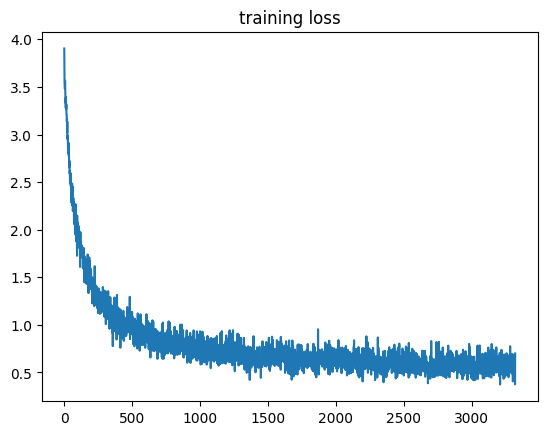

In [ ]:
plt.plot(losses);
plt.title("training loss");

In [ ]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


In [ ]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #1. Expected: right. Predicted: seven.


In [ ]:
torch.save({
            'epoch': n_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': losses[-1],
            }, 'model_checkpoint.pth')

#**Custom Dataset**
30 samples for each of the 35 labels

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import soundfile as sf
from torch.utils.data import Dataset

class AudioDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.audio_files = []
        self.labels = []
        self.label_names = []

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for file_name in os.listdir(class_dir):
                    if file_name.endswith('.wav'):
                        file_path = os.path.join(class_dir, file_name)
                        self.audio_files.append(file_path)
                        self.labels.append(label)
                        self.label_names.append(class_name)

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_path = self.audio_files[idx]
        label = self.labels[idx]
        label_name = self.label_names[idx]

        # Use soundfile to load the audio
        waveform, sample_rate = sf.read(audio_path, dtype='float32')
        waveform = torch.tensor(waveform).unsqueeze(0)  # Add channel dimension

        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resampler(waveform)

        if self.transform:
            waveform = self.transform(waveform)

        return waveform, sample_rate, label, label_name

# Usage Example:
root_dir = '/content/drive/MyDrive/CUSTOM COMMANDS'
dataset = AudioDataset(root_dir=root_dir)

In [ ]:
len(dataset)

1050

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 8000
3
cat


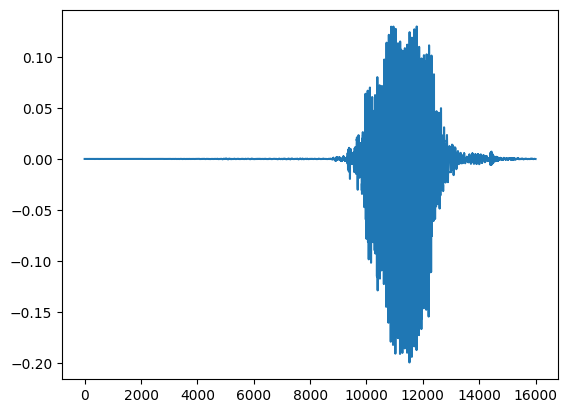

In [ ]:
import matplotlib.pyplot as plt
waveform, sample_rate, label, ln= dataset[100]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
print(label)
print(ln)
plt.plot(waveform.t().numpy());

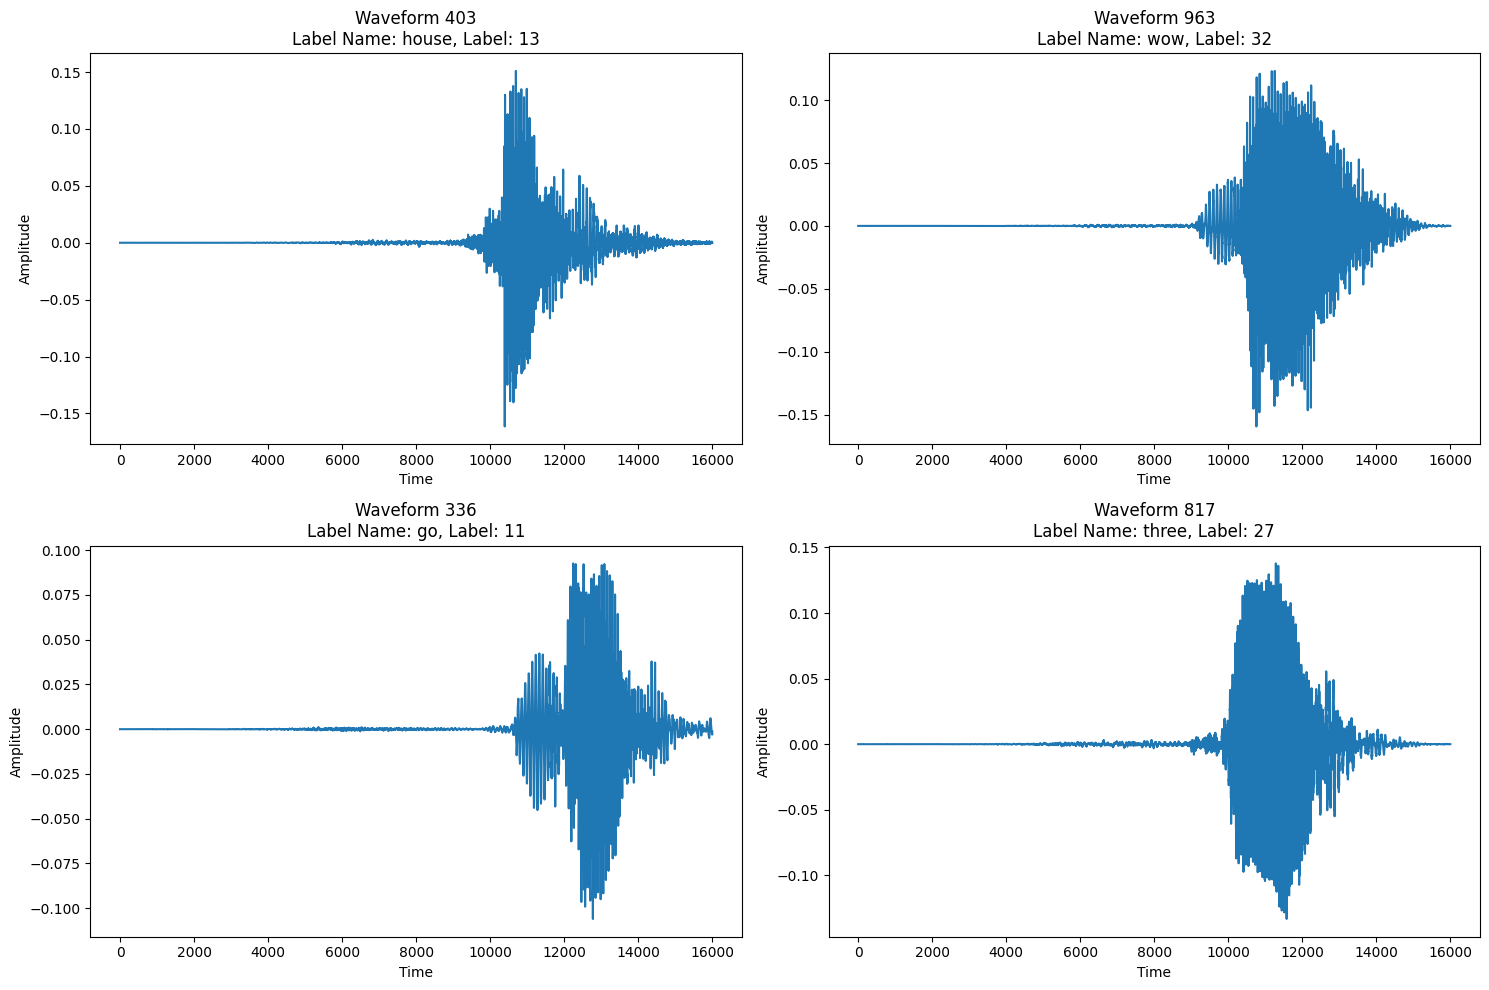

In [ ]:
def plot_waveforms(t, num_samples=4):
    # Randomly select num_samples from the dataset
    selected_indices = random.sample(range(len(t)), num_samples)

    # Create a 2x2 grid for plotting
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Flatten the 2x2 grid for easier indexing
    axs = axs.flatten()

    # Plot each selected waveform
    for i, idx in enumerate(selected_indices):
        waveform, sample_rate, label, ln = t[idx]
        waveform_np = waveform.t().numpy()

        axs[i].plot(waveform_np)
        axs[i].set_title(f"Waveform {idx}\nLabel Name: {ln}, Label: {label}")
        axs[i].set_xlabel("Time")
        axs[i].set_ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

# Call the function to plot 4 random waveforms
plot_waveforms(dataset)

In [ ]:
waveform_first,sample_rate, label, ln = dataset[1000]
ipd.Audio(waveform_first.numpy(), rate=16000)

Let's Try on the current training

In [ ]:
print(ln ,":",predict(waveform_first))

yes : yes


In [ ]:
incorrect = 0
for i, (waveform, sample_rate, label, ln) in enumerate(dataset):
    output = predict(waveform)
    if output != ln:
        incorrect += 1

In [ ]:
print(f"Number of incorrect predictions: {incorrect}")
print("Accuracy:",((len(dataset)-incorrect)*100) / len(dataset),"%")

Number of incorrect predictions: 558
Accuracy: 46.857142857142854 %


So the current Accuracy with the current stage of training the the accuracy is **46.9%**

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [ ]:
train_dataset[800]

(tensor([[ 2.3011e-07,  5.5394e-06, -2.8501e-07,  ...,  1.9728e-02,
           2.1787e-02,  1.2266e-02]]),
 8000,
 7,
 'five')

In [ ]:
def collate_fn(batch):
    tensors, targets = [], []
    for waveform, sample_rate, label, ln in batch:
        tensors += [waveform]
        targets += [label_to_index(ln)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [ ]:
# Assuming your checkpoint is saved as 'model_checkpoint.pth'
checkpoint = torch.load('model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
n_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']

<ipython-input-100-2f7cd1a0479f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_checkpoint.pth')


In [ ]:
print(model)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)


In [ ]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.01
    maximize: False
    weight_decay: 0.0001
)


In [ ]:
log_interval = 10
n_epoch = 3

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm.tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

  1%|          | 0.029850746268656716/3 [00:00<00:44, 14.85s/it]

Train Epoch: 1 [0/840 (0%)]	Loss: 2.160219


  6%|▌         | 0.17910447761194026/3 [00:01<00:27,  9.72s/it]

Train Epoch: 1 [160/840 (19%)]	Loss: 0.564589


 11%|█         | 0.3283582089552237/3 [00:03<00:23,  8.85s/it]

Train Epoch: 1 [320/840 (38%)]	Loss: 1.318751


 16%|█▌        | 0.4776119402985072/3 [00:04<00:23,  9.23s/it] 

Train Epoch: 1 [480/840 (57%)]	Loss: 1.798345


 21%|██        | 0.6268656716417911/3 [00:06<00:26, 11.30s/it]

Train Epoch: 1 [640/840 (75%)]	Loss: 0.106985


 26%|██▌       | 0.7761194029850751/3 [00:07<00:21,  9.74s/it]

Train Epoch: 1 [800/840 (94%)]	Loss: 0.319790


14.805970149253731it [00:09,  6.94it/s]


Test Epoch: 1	Accuracy: 176/210 (84%)

Train Epoch: 2 [0/840 (0%)]	Loss: 0.398103
Train Epoch: 2 [160/840 (19%)]	Loss: 0.469966
Train Epoch: 2 [320/840 (38%)]	Loss: 0.513365
Train Epoch: 2 [480/840 (57%)]	Loss: 0.093303
Train Epoch: 2 [640/840 (75%)]	Loss: 0.542344


15.522388059701505it [00:16,  2.33s/it]

Train Epoch: 2 [800/840 (94%)]	Loss: 0.131756


29.59701492537315it [00:18,  7.35it/s]


Test Epoch: 2	Accuracy: 197/210 (94%)

Train Epoch: 3 [0/840 (0%)]	Loss: 0.167618
Train Epoch: 3 [160/840 (19%)]	Loss: 0.251099
Train Epoch: 3 [320/840 (38%)]	Loss: 0.010041
Train Epoch: 3 [480/840 (57%)]	Loss: 0.086906
Train Epoch: 3 [640/840 (75%)]	Loss: 0.014961
Train Epoch: 3 [800/840 (94%)]	Loss: 0.004139


44.37313432835823it [00:26,  1.66it/s]


Test Epoch: 3	Accuracy: 210/210 (100%)



# So we got a 100% Accuracy after training further on the customer dataset.

In [ ]:
incorrect = 0
for i, (waveform, sample_rate, label, ln) in enumerate(test_dataset):
    output = predict(waveform)
    if output != ln:
        incorrect += 1

In [ ]:
print(f"Number of incorrect predictions: {incorrect}")
print("Accuracy:",((len(dataset)-incorrect)*100) / len(dataset),"%")

Number of incorrect predictions: 0
Accuracy: 100.0 %


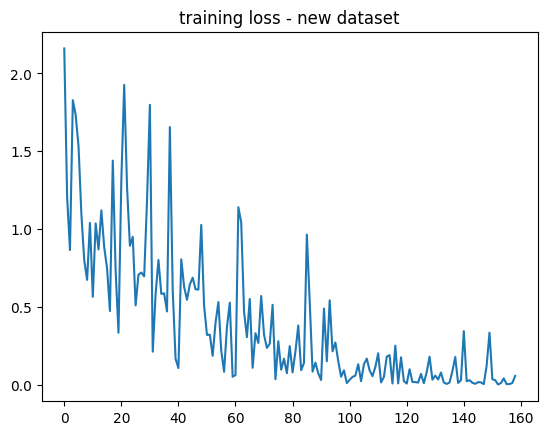

In [ ]:
plt.plot(losses);
plt.title("training loss - new dataset");

Saving the Custom Model

In [ ]:
torch.save({
            'epoch': n_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': losses[-1],
            }, 'CustomDataset_model_checkpoint.pth')

Testing in real-time (Record and test)

In [ ]:
waveform, sample_rate = torchaudio.load('/content/testing.wav')

In [ ]:
predict(waveform)

'bed'

In [ ]:
ipd.Audio(waveform.numpy(), rate=16000)